In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

In [34]:
def get_donut_data():
    N=600
    R_inner=10
    R_outer=20
    R1 = np.random.randn(N/2)+R_inner
    theta = np.random.random(N/2)*2*np.pi
    X_inner = np.concatenate([[R1*np.cos(theta)], [R1*np.sin(theta)]]).T
    R2 = np.random.randn(N/2)+R_outer
    theta = np.random.random(N/2)*2*np.pi
    X_outer = np.concatenate([[R2*np.cos(theta)], [R2*np.sin(theta)]]).T
    X= np.concatenate([X_inner, X_outer])
    Y = np.array([0]*int((N/2))+[1]*int((N/2)))
    return X,Y

In [35]:
def main():
    X,Y = get_donut_data()
    plt.scatter(X[:,0],X[:,1], c=Y, s=100, alpha=0.5)
    plt.show()
    tsne = TSNE(perplexity=40)
    Z = tsne.fit_transform(X)
    plt.scatter(Z[:,0], Z[:,1], c=Y, s=100, alpha=0.5)
    plt.show()
    

In [36]:
if __name__=='main':
    main()

/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


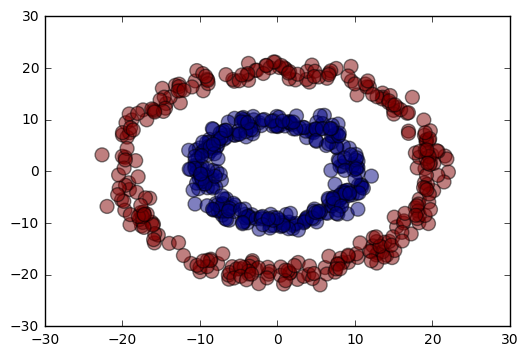

ValueError: array must not contain infs or NaNs

In [38]:
main()

In [39]:
X.isnull()

NameError: name 'X' is not defined

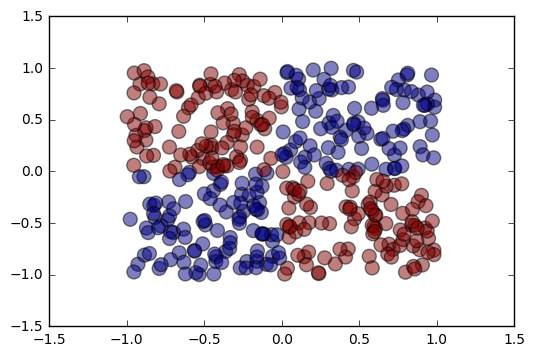

ValueError: array must not contain infs or NaNs

In [40]:
def get_xor_data():
    X1 = np.random.random((100, 2))
    X2 = np.random.random((100, 2)) - np.array([1, 1])
    X3 = np.random.random((100, 2)) - np.array([1, 0])
    X4 = np.random.random((100, 2)) - np.array([0, 1])
    X = np.vstack((X1, X2, X3, X4))
    Y = np.array([0]*200 + [1]*200)
    return X, Y


def main():
    X, Y = get_xor_data()

    plt.scatter(X[:,0], X[:,1], s=100, c=Y, alpha=0.5)
    plt.show()

    tsne = TSNE(perplexity=40)
    Z = tsne.fit_transform(X)
    plt.scatter(Z[:,0], Z[:,1], s=100, c=Y, alpha=0.5)
    plt.show()

if __name__ == '__main__':
    main()

In [2]:
from util import relu, error_rate, getKaggleMNIST, init_weights
from sklearn.utils import shuffle
import theano
import theano.tensor as T

In [27]:
class AutoEncoder(object):
    def __init__(self, M, an_id):
        self.M = M
        self.id = an_id
    
    def fit(self, X, learning_rate=0.5, mu=0.99, epochs=1, batch_sz=100, show_fig=True):
        N, D = X.shape
        n_batches = int(N/batch_sz)
        W0 = init_weights((D, self.M))
        self.W = theano.shared(W0, 'W_%s' %self.id)
        self.bh = theano.shared(np.zeros(self.M), 'bh_%s' %self.id)
        self.bo = theano.shared(np.zeros(D), 'bo_%s' %self.id)
        self.params = [self.W, self.bh, self.bo]
        self.forward_params = [self.W, self.bh]
        self.dW = theano.shared(np.zeros(W0.shape), 'dW_%s' %self.id)
        self.dbh = theano.shared(np.zeros(self.M), 'dbh_%s' %self.id)
        self.dbo = theano.shared(np.zeros(D), 'dbo_%s' %self.id)
        self.dparams = [self.dW, self.dbh, self.dbo]
        self.forward_dparams = [self.dW, self.dbh]
        
        X_in = T.matrix('X_%s' %self.id)
        X_hat = self.forward_output(X_in)
        
        H = T.nnet.sigmoid(X_in.dot(self.W) +self.bh)
        self.hidden_op = theano.function(
            inputs = [X_in],
            outputs = H
        )
        cost = ((X_in-X_hat)*(X_in-X_hat)).sum()/N
        #cost = -(X_in*T.log(X_hat)+(1-X_in)*T.log(1-X_hat)).sum()/N
        cost_op = theano.function(
            inputs = [X_in],
            outputs = cost
        )
        updates = [ (p, p + mu*dp-learning_rate*T.grad(cost, p)) for p,dp in zip(self.params, self.dparams)]+\
            [(dp, mu*dp-learning_rate*T.grad(cost,p)) for p, dp in zip(self.params, self.dparams)]
            
        train_op = theano.function(
            inputs = [X_in],
            updates = updates
        )
        costs = []
        print('Starting training %s' %self.id)
        for i in range(epochs):
            print('epoch: ', i)
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:((j+1)*batch_sz)]
                train_op(batch)
                the_cost = cost_op(X)
                print('j/n bathces', j, '/', n_batches, 'cost', the_cost)
                costs.append(the_cost)
        if show_fig:
            plt.plot(costs)
            plt.show()
            
    def forward_hidden(self, X):
        Z = T.nnet.sigmoid(X.dot(self.W)+self.bh)
        return Z
    
    def forward_output(self, X):
        Z = self.forward_hidden(X)
        Y = T.nnet.sigmoid(Z.dot(self.W.T)+self.bo)
        return Y
    
        
                
        
        

In [28]:
class DNN(object):
    def __init__(self, hidden_layer_sizes, UnsupervisedModel=AutoEncoder):
        self.hidden_layers=[]
        count = 0
        for M in hidden_layer_sizes:
            ae = UnsupervisedModel(M, count)
            self.hidden_layers.append(ae)
            count += 1
    
    def fit(self, X, Y, Xtest, Ytest, pretrain=True, learning_rate=0.1, mu=0.99, reg=0.1, epochs=1, batch_sz=100):
        pretrain_epochs=1
        if not pretrain:
            pretrain_epochs = 0
        current_input = X
        for ae in self.hidden_layers:
            ae.fit(current_input, epochs=pretrain_epochs)
            current_input = ae.hidden_op(current_input)
        N = len(Y)
        K = len(set(Y))
        W0 = init_weigths((self.hidden_layers[-1].M,K))
        self.W = theano.shared(W0, 'W_logreg')
        self.b = theano.shared(np.zeros(K), 'b_logreg')
        self.params = [self.W, self.b]
        for ae in self.hidden_layers:
            self.params += ae.forward_params
        
        self.dW = theano.shared(np.zeros(W0.shape), 'dW_logreg')
        self.db = theano.shared(np.zeros(K), 'db_logreg')
        self.dparams = [self.dW, self.db]
        for ae in self.hidden_layers:
            self.dparams += ae.forward_dparams
        
        X_in = T.matrix('X_in')
        targets = T.ivector('Targets')
        pY = self.forward(X_in)
        
        squared_magintude = [(p*p) for p in self.params]
        reg_cost = T.sum(squared_magintude)
        cost = T.mean(T.log(pY[T.arange(pY.shape[0]), targets])) + reg_cost
        prediction = self.predict(X_in)
        cost_predict_op = theano.function(
            inputs = [X_in, targets],
            outputs = [cost, prediction]
        )
        updates = [ (p, p + mu*dp-learning_rate*T.grad(cost, p)) for p,dp in zip(self.params, self.dparams)]+\
            [(dp, mu*dp-learning_rate*T.grad(cost,p)) for p, dp in zip(self.params, self.dparams)]
        
        train_op = theano.function(
            inputs=[X_in, targets],
            updates = updates
        )
        
        n_batches = int(N/batch_sz)
        costs=[]
        print('supervised training')
        for i in range(epochs):
            print('epoch:', i)
            X, Y = shuffle(X,Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j+1)*batch_sz]
                Ybatch = Y[j*batch_sz:(j+1)*batch_sz]
                train_op(Xbatch, Ybatch)
                the_cost, the_prediction = cost_predict_op(Xtest, Ytest)
                error = error_rate(the_prediction, Ytest)
                print('j/n bathces', j, '/', n_batches, 'cost:', the_cost)
                costs.append(the_cost)
        plt.plot(costs)
        plt.show()
    
    def predict(self, X):
        return T.argmax(self.forward(X), axis=1)
    
    def forward(self, X):
        current_input = X
        for ae in self.hidden_layers:
            Z = ae.forward_hidden(current_input)
            current_input = Z
        Y = T.nnet.softmax(T.dot(current_input, self.W)+self.b)
        return Y
    

        

In [29]:
def main():
    Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
    dnn = DNN([1000,700,500])
    dnn.fit(Xtrain, Ytrain, Xtest, Ytest, epochs=3 )

In [30]:
main()

Starting training 0
epoch:  0


TypeError: 'float' object cannot be interpreted as an integer

In [44]:
class AutoEncoder(object):
    def __init__(self, M, an_id):
        self.M = M
        self.id = an_id

    def fit(self, X, learning_rate=0.5, mu=0.99, epochs=1, batch_sz=100, show_fig=False):
        N, D = X.shape
        n_batches = int(N / batch_sz)

        W0 = init_weights((D, self.M))
        self.W = theano.shared(W0, 'W_%s' % self.id)
        self.bh = theano.shared(np.zeros(self.M), 'bh_%s' % self.id)
        self.bo = theano.shared(np.zeros(D), 'bo_%s' % self.id)
        self.params = [self.W, self.bh, self.bo]
        self.forward_params = [self.W, self.bh]

        # TODO: technically these should be reset before doing backprop
        self.dW = theano.shared(np.zeros(W0.shape), 'dW_%s' % self.id)
        self.dbh = theano.shared(np.zeros(self.M), 'dbh_%s' % self.id)
        self.dbo = theano.shared(np.zeros(D), 'dbo_%s' % self.id)
        self.dparams = [self.dW, self.dbh, self.dbo]
        self.forward_dparams = [self.dW, self.dbh]

        X_in = T.matrix('X_%s' % self.id)
        X_hat = self.forward_output(X_in)

        # attach it to the object so it can be used later
        # must be sigmoidal because the output is also a sigmoid
        H = T.nnet.sigmoid(X_in.dot(self.W) + self.bh)
        self.hidden_op = theano.function(
            inputs=[X_in],
            outputs=H,
        )

        # cost = ((X_in - X_hat) * (X_in - X_hat)).sum() / N
        cost = -(X_in * T.log(X_hat) + (1 - X_in) * T.log(1 - X_hat)).sum() / (batch_sz * D)
        cost_op = theano.function(
            inputs=[X_in],
            outputs=cost,
        )

        updates = [
            (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ] + [
            (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ]
        train_op = theano.function(
            inputs=[X_in],
            updates=updates,
        )

        costs = []
        print("training autoencoder: %s" % self.id)
        for i in range(epochs):
            print("epoch:", i)
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(batch)
                the_cost = cost_op(X) # technically we could also get the cost for Xtest here
                print("j / n_batches:", j, "/", n_batches, "cost:", the_cost)
                costs.append(the_cost)
        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward_hidden(self, X):
        Z = T.nnet.sigmoid(X.dot(self.W) + self.bh)
        # Z = T.tanh(X.dot(self.W) + self.bh)
        # Z = relu(X.dot(self.W) + self.bh)
        return Z

    def forward_output(self, X):
        Z = self.forward_hidden(X)
        Y = T.nnet.sigmoid(Z.dot(self.W.T) + self.bo)
        return Y

    @staticmethod
    def createFromArrays(W, bh, bo, an_id):
        ae = AutoEncoder(W.shape[1], an_id)
        ae.W = theano.shared(W, 'W_%s' % ae.id)
        ae.bh = theano.shared(bh, 'bh_%s' % ae.id)
        ae.bo = theano.shared(bo, 'bo_%s' % ae.id)
        ae.params = [ae.W, ae.bh, ae.bo]
        ae.forward_params = [ae.W, ae.bh]
        return ae


class DNN(object):
    def __init__(self, hidden_layer_sizes, UnsupervisedModel=AutoEncoder):
        self.hidden_layers = []
        count = 0
        for M in hidden_layer_sizes:
            ae = UnsupervisedModel(M, count)
            self.hidden_layers.append(ae)
            count += 1


    def fit(self, X, Y, Xtest, Ytest, pretrain=True, learning_rate=0.01, mu=0.99, reg=0.1, epochs=1, batch_sz=100):
        # greedy layer-wise training of autoencoders
        pretrain_epochs = 1
        if not pretrain:
            pretrain_epochs = 0

        current_input = X
        for ae in self.hidden_layers:
            ae.fit(current_input, epochs=pretrain_epochs)

            # create current_input for the next layer
            current_input = ae.hidden_op(current_input)

        # initialize logistic regression layer
        N = len(Y)
        K = len(set(Y))
        W0 = init_weights((self.hidden_layers[-1].M, K))
        self.W = theano.shared(W0, "W_logreg")
        self.b = theano.shared(np.zeros(K), "b_logreg")

        self.params = [self.W, self.b]
        for ae in self.hidden_layers:
            self.params += ae.forward_params

        # for momentum
        self.dW = theano.shared(np.zeros(W0.shape), "dW_logreg")
        self.db = theano.shared(np.zeros(K), "db_logreg")
        self.dparams = [self.dW, self.db]
        for ae in self.hidden_layers:
            self.dparams += ae.forward_dparams

        X_in = T.matrix('X_in')
        targets = T.ivector('Targets')
        pY = self.forward(X_in)

        # squared_magnitude = [(p*p).sum() for p in self.params]
        # reg_cost = T.sum(squared_magnitude)
        cost = -T.mean( T.log(pY[T.arange(pY.shape[0]), targets]) ) #+ reg*reg_cost
        prediction = self.predict(X_in)
        cost_predict_op = theano.function(
            inputs=[X_in, targets],
            outputs=[cost, prediction],
        )

        updates = [
            (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ] + [
            (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ]
        # updates = [(p, p - learning_rate*T.grad(cost, p)) for p in self.params]
        train_op = theano.function(
            inputs=[X_in, targets],
            updates=updates,
        )

        n_batches = int(N / batch_sz)
        print('n_batches:', n_batches)
        costs = []
        print("supervised training...")
        for i in range(epochs):
            print("epoch:", i)
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(Xbatch, Ybatch)
                the_cost, the_prediction = cost_predict_op(Xtest, Ytest)
                error = error_rate(the_prediction, Ytest)
                print("j / n_batches:", j, "/", n_batches, "cost:", the_cost, "error:", error)
                costs.append(the_cost)
        plt.plot(costs)
        plt.show()

    def predict(self, X):
        return T.argmax(self.forward(X), axis=1)

    def forward(self, X):
        current_input = X
        for ae in self.hidden_layers:
            Z = ae.forward_hidden(current_input)
            current_input = Z

        # logistic layer
        Y = T.nnet.softmax(T.dot(current_input, self.W) + self.b)
        return Y


def main():
    Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
    dnn = DNN([1000, 750, 500])
    dnn.fit(Xtrain, Ytrain, Xtest, Ytest, epochs=1)
    # vs
    #dnn = DNN([1000, 750, 500])
    #dnn.fit(Xtrain, Ytrain, Xtest, Ytest, pretrain=False, epochs=3)



In [45]:
main()

training autoencoder: 0
epoch: 0
j / n_batches: 0 / 410 cost: 277.3324594527529
j / n_batches: 1 / 410 cost: 256.811129979131
j / n_batches: 2 / 410 cost: 230.5261818970943
j / n_batches: 3 / 410 cost: 202.52475336224074
j / n_batches: 4 / 410 cost: 176.48789449665964
j / n_batches: 5 / 410 cost: 154.72759386849012
j / n_batches: 6 / 410 cost: 138.05166296283235
j / n_batches: 7 / 410 cost: 126.16325435896343
j / n_batches: 8 / 410 cost: 118.23919484937022
j / n_batches: 9 / 410 cost: 113.33322243481193
j / n_batches: 10 / 410 cost: 110.60238148132522
j / n_batches: 11 / 410 cost: 109.3549940206139
j / n_batches: 12 / 410 cost: 109.08297915184227
j / n_batches: 13 / 410 cost: 109.4149949461493
j / n_batches: 14 / 410 cost: 110.07993782574552
j / n_batches: 15 / 410 cost: 110.88324501194082
j / n_batches: 16 / 410 cost: 111.7228366558684
j / n_batches: 17 / 410 cost: 112.52565210585239
j / n_batches: 18 / 410 cost: 113.25700630911481
j / n_batches: 19 / 410 cost: 113.89678596378467
j / 

KeyboardInterrupt: 